In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
import itertools
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

In [2]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)  
print(device)

cpu


In [3]:
input_dim = 10
output_dim = 1
num_epochs = 15
batch_size = 128
learn_rate = 0.0001

In [4]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32)).float().to(device)
        self.y = torch.from_numpy(y.astype(np.float32)).float().to(device)
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2, output_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim1)
        self.layer_2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer_3 = nn.Linear(hidden_dim2, output_dim)
       
    def forward(self, x):
        x = torch.relu(self.layer_1(x))
        x = torch.relu(self.layer_2(x))
        x = torch.sigmoid(self.layer_3(x))

        return x

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Cross validation preparation

In [7]:
# read data
g70 = pd.read_csv('/content/drive/MyDrive/bonusData/gammas70.csv').values.tolist()
h70 = pd.read_csv('/content/drive/MyDrive/bonusData/hadrons70.csv').values.tolist()

## Split the data into 10 folds.

In [8]:
k_fold = []

for i in range(0,4):

  k_fold.append(g70[i*936 : i*936 + 936] + h70[i*936 : i*936 + 936])

k_fold.append(g70[3744 : 4682] + h70[3744 : 4682])

In [9]:
print(len(k_fold[0]))
print(len(k_fold[1]))
print(len(k_fold[2]))
print(len(k_fold[3]))
print(len(k_fold[4]))

1872
1872
1872
1872
1876


In [10]:
def getTrain(k_fold, k):
  train = []
  for i in range(0,5):
    if k == i:
      continue
    train = train + k_fold[i];

  return train

In [11]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [12]:
def round_tensor(t, decimal_places=5):
  return round(t.item(), decimal_places)

## Start cross validation

In [13]:
ans = []
loss_fn = nn.BCELoss()
for i in range(1,100,10):
  tempRow = []
  for j in range(1,100,10):
    acc = 0
    if (j-i<=30 and j>=i) or (j-i>=-30 and j<=i):
      for k in range(0,5):
        vld = pd.DataFrame(k_fold[k])
        trn = pd.DataFrame(getTrain(k_fold, k))
        X_vld = vld.iloc[:, :-1].values
        y_vld = vld.iloc[:, -1].values

        X_trn = trn.iloc[:, :-1].values
        y_trn = trn.iloc[:, -1].values

        scaler = StandardScaler()
        scaler.fit(X_trn)
        X_trn = scaler.transform(X_trn)
        X_vld = scaler.transform(X_vld)

        train_data = Data(X_trn, y_trn)
        train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)

        test_data = Data(X_vld, y_vld)
        test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

        tempModel = NeuralNetwork(10,i,j,1)
        tempModel = tempModel.to(device)
        optimizer = torch.optim.Adam(tempModel.parameters())
      
        tempModel.train()
        for epoch in range(50):
          for X, y in train_dataloader:
            optimizer.zero_grad()
            X = X.to(device)
            y = y.to(device)
            pred = tempModel(X)
            loss = loss_fn(pred, y.unsqueeze(-1))
            loss.backward()
            optimizer.step()

        accTemp = 0
        for X, y in test_dataloader:
          X = X.to(device)
          y = y.to(device)
          pred = tempModel(X)
          pred = torch.squeeze(pred)
          accTemp += round_tensor(calculate_accuracy(y, pred))

        accTemp = accTemp / 15
        acc = acc + accTemp

      acc = acc / 5
    else:
      acc = 0

    tempRow.append(acc)
    print('i = ',i,'j = ', j, acc, tempRow)

  ans.append(tempRow)

i =  1 j =  1 0.7163962666666666 [0.7163962666666666]
i =  1 j =  11 0.7710693333333334 [0.7163962666666666, 0.7710693333333334]
i =  1 j =  21 0.7741362666666666 [0.7163962666666666, 0.7710693333333334, 0.7741362666666666]
i =  1 j =  31 0.7743483999999998 [0.7163962666666666, 0.7710693333333334, 0.7741362666666666, 0.7743483999999998]
i =  1 j =  41 0 [0.7163962666666666, 0.7710693333333334, 0.7741362666666666, 0.7743483999999998, 0]
i =  1 j =  51 0 [0.7163962666666666, 0.7710693333333334, 0.7741362666666666, 0.7743483999999998, 0, 0]
i =  1 j =  61 0 [0.7163962666666666, 0.7710693333333334, 0.7741362666666666, 0.7743483999999998, 0, 0, 0]
i =  1 j =  71 0 [0.7163962666666666, 0.7710693333333334, 0.7741362666666666, 0.7743483999999998, 0, 0, 0, 0]
i =  1 j =  81 0 [0.7163962666666666, 0.7710693333333334, 0.7741362666666666, 0.7743483999999998, 0, 0, 0, 0, 0]
i =  1 j =  91 0 [0.7163962666666666, 0.7710693333333334, 0.7741362666666666, 0.7743483999999998, 0, 0, 0, 0, 0, 0]
i =  11 j 

In [14]:
print(ans)
print(device)

[[0.7163962666666666, 0.7710693333333334, 0.7741362666666666, 0.7743483999999998, 0, 0, 0, 0, 0, 0], [0.8035001333333331, 0.8232029333333333, 0.8264890666666667, 0.8281974666666667, 0.8276769333333334, 0, 0, 0, 0, 0], [0.8242601333333333, 0.8317022666666667, 0.8351317333333332, 0.8369234666666667, 0.8333058666666668, 0.8414778666666665, 0, 0, 0, 0], [0.8289264, 0.8378110666666666, 0.8407185333333335, 0.8421946666666666, 0.8393393333333332, 0.8420222666666666, 0.8416145333333332, 0, 0, 0], [0, 0.8394989333333334, 0.8386266666666666, 0.8397149333333334, 0.8428761333333334, 0.8415565333333334, 0.8427726666666666, 0.8449730666666666, 0, 0], [0, 0, 0.8437234666666665, 0.8437150666666666, 0.843564, 0.8436602666666667, 0.8452642666666668, 0.8440928, 0.8438012, 0], [0, 0, 0, 0.8416638666666667, 0.8448556, 0.8434317333333332, 0.8444727999999999, 0.8457938666666667, 0.8475144, 0.8455930666666667], [0, 0, 0, 0, 0.8438972, 0.8461896, 0.8452853333333333, 0.8454338666666666, 0.8471812, 0.84543200000

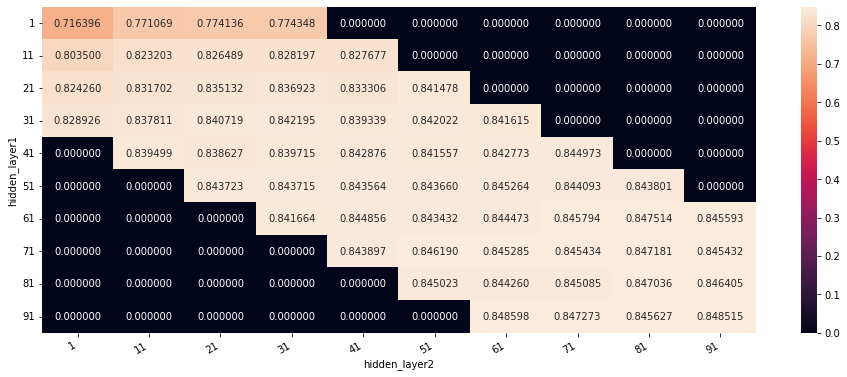

In [15]:
labels = ['1','11','21','31','41','51','61','71','81','91']
df_cm = pd.DataFrame(ans, index=labels, columns=labels)
plt.figure(figsize = (16,6))
hmap = sns.heatmap(df_cm, annot=True, fmt="f")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('hidden_layer1')
plt.xlabel('hidden_layer2');

In [16]:
hidd1 = 0
hidd2 = 0
maxAcc = ans[0][0]
for i in range(10):
  for  j in range(10):
    if(ans[i][j] > maxAcc):
      maxAcc = ans[i][j]
      hidd1 = i
      hidd2 = j
hidd1 = 1 + hidd1*10
hidd2 = 1 + hidd2*10
print(hidd1, hidd2)

91 61


In [17]:
hidden_dim1 = hidd1
hidden_dim2 = hidd2
print(hidden_dim1)
print(hidden_dim2)

91
61


# **Training preparation**

In [18]:
# read data
trainingSet = pd.read_csv('/content/drive/MyDrive/bonusData/training.csv')
testingSet = pd.read_csv('/content/drive/MyDrive/bonusData/testing.csv')

In [19]:
# training data
x_train = trainingSet.iloc[:, :-1].values  # features
y_train = trainingSet.iloc[:, -1].values  # labels
x_test = testingSet.iloc[:, :-1].values  # features
y_test = testingSet.iloc[:, -1].values  # labels

In [20]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [21]:
train_data = Data(x_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)

test_data = Data(x_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

## Model creation

In [22]:
model = NeuralNetwork(input_dim, hidden_dim1, hidden_dim2, output_dim)
model = model.to(device)

In [23]:
loss_fn = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters())

## Start training

In [24]:
loss_values = np.array([])

for epoch in range(num_epochs):
    for X, y in train_dataloader:
        optimizer.zero_grad()
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y.unsqueeze(-1))
        loss_values = np.append(loss_values,loss.item())
        loss.backward()
        optimizer.step()
    print(f'Epoch num {epoch}')
    print("--------------------------")

print("Training Complete")

Epoch num 0
--------------------------
Epoch num 1
--------------------------
Epoch num 2
--------------------------
Epoch num 3
--------------------------
Epoch num 4
--------------------------
Epoch num 5
--------------------------
Epoch num 6
--------------------------
Epoch num 7
--------------------------
Epoch num 8
--------------------------
Epoch num 9
--------------------------
Epoch num 10
--------------------------
Epoch num 11
--------------------------
Epoch num 12
--------------------------
Epoch num 13
--------------------------
Epoch num 14
--------------------------
Training Complete


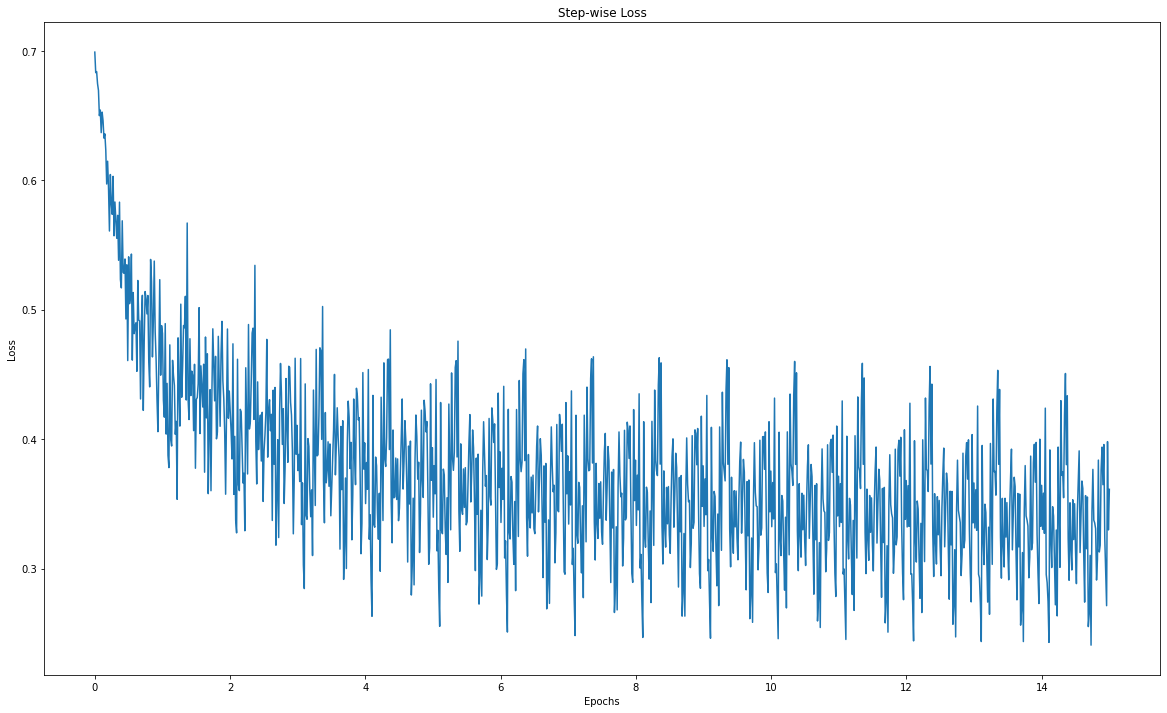

In [25]:
step = np.linspace(0, num_epochs, loss_values.shape[0])

fig, ax = plt.subplots(figsize=(20,12))
plt.plot(step,loss_values)
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## Start testing

In [26]:
num_correct = 0
num_samples = 0
y_pred = np.array([])

model.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)
        outputs = model(X)
        predicted = np.where(outputs.cpu().data.numpy() <= 0.5, 0, 1)
        predicted = list(itertools.chain(*predicted))
        y_pred = np.append(y_pred,predicted)
        num_correct += (predicted == y.cpu().data.numpy()).sum().item()
        num_samples += y.size(0)
print(f'Correct = {num_correct} and total = {num_samples} then accuracy = {100* num_correct // num_samples}%')

Correct = 3386 and total = 4012 then accuracy = 84%


# Statistics

In [27]:
print(classification_report(torch.from_numpy(y_test), torch.from_numpy(y_pred)))

              precision    recall  f1-score   support

           0       0.89      0.78      0.83      2006
           1       0.81      0.91      0.85      2006

    accuracy                           0.84      4012
   macro avg       0.85      0.84      0.84      4012
weighted avg       0.85      0.84      0.84      4012



In [28]:
cm = confusion_matrix(y_test, y_pred)

In [29]:
labels = ['h','g']
columns = [f'Predicted {label}' for label in labels]
index = [f'Actual {label}' for label in labels]
table = pd.DataFrame(cm, columns=columns, index=index)
table

,Predicted h,Predicted g
Actual h,1565,441
Actual g,185,1821


In [30]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
specificity = cm[0,0]/(cm[0,0] + cm[0,1])
f1 = f1_score(y_test, y_pred)

print('model_accuracy = ', acc)
print('model_precision = ', prec)
print('model_recall = ', recall)
print('model_specificity = ', specificity)
print('model_f1 = ', f1)

model_accuracy =  0.8439680957128615
model_precision =  0.8050397877984085
model_recall =  0.9077766699900299
model_specificity =  0.7801595214356929
model_f1 =  0.8533270852858482
